In [3]:
from catboost import CatBoostClassifier
modelcb = CatBoostClassifier()
modelcb.load_model('../models/cb_model4_v2_06214.cbm', format="cbm")

In [4]:
import pandas as pd
import numpy as np
from collections import Counter
import random as r
from sklearn.model_selection import train_test_split
dt = pd.read_csv('../data/model4.csv').dropna()

# откуда то при пересохранении в csv образуется лишний столбец
dt.drop(dt.columns[[0]], axis = 1, inplace = True)

dt.OWN_REG = dt.OWN_REG.apply(lambda x: str(x))
dt = dt[(dt['TS_POWER'] < 1000) & (dt['TS_POWER'] > 30) & (dt['INS_YEAR'] > 18)]
dt = dt[['AGR_SRC', 'AGR_CREATEDBY',#, 'car' 
       'OWN_REG', 'AGR_KBM', 'TS_MARK_NAME', 'TS_MODEL_NAME',
       'TS_POWER', 'TS_USE_NAME', 'f1_daysbeforestart',
       'f6_car_age_on_start', 'f13_is_prolongation', 'f14_drivers_count',
       'f15_kbm_min', 'f16_drv_age_min', 'f17_drv_age_max',
       'f18_drv_skill_min', 'f19_drv_skill_max', 'f20_oneperson',
       'f21_agr_days', 'claim']]

# балансируем классы и разбиваем на выборки
dt['cat'] = dt['claim'].apply(lambda x: r.choice(list(range(1, 6))) if x==1 else r.choice(list(range(10, 30))))
trn = dt[dt['cat'].isin([10, 2, 3, 4, 5, 22, 23, 24, 25, 26, 27, 28, 29])]
tst = dt[dt['cat'].isin([1,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])].drop('cat', axis = 1)

dt2 = trn[(trn['AGR_KBM'] < 0.95) & (trn['AGR_KBM'] > 1)]
dt3 = trn[trn['claim'] == 1]
# print(dt3.shape, Counter(dt3.claim))
dt = dt.append(dt2).append(dt3)


# пополняем выборку значениями upsample
trn = dt[dt['cat'].isin([10, 2, 3, 4, 5, 22, 23, 24, 25, 26, 27, 28, 29])].drop('cat', axis = 1)

X = dt.drop(['claim'], axis = 1)
Y = dt.claim


X_train = trn.drop(['claim'], axis = 1)
X_test = tst.drop(['claim'], axis = 1)
y_train = trn.claim
y_test = tst.claim

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
from scipy.optimize import minimize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report,f1_score

def mtr(m, x = X_test, y = y_test, limit = 0, metrics = 'AUC', 
        meanclaim = 66304, meanpremium = 6946, meankv = 0.18):
    '''
    Функция оптимизирует предсказания модели бинарной классификации по порогу принятия решения и 
    оценивает эффективность в  ROC-AUC (AUC) и в деньгах (money)
    '''
    pr = m.predict(x)
    if limit == 0:
        pred = pr
    elif limit == 1:
        def min(limit, m=m):
            s = m.predict_proba(x)
            r = []
            for i in s:
                if i[0] > limit:
                    r.append(0)
                else:
                    r.append(1)
            if metrics == 'AUC':
                res = roc_auc_score(y, r)
            elif metrics == 'money':
                cm = confusion_matrix(y, r)
                res = (cm[0][0] + cm[1][0])*meanpremium*(1-meankv) - cm[1][0]*meanclaim
                
            return -res
        l = minimize(min, 0.5, method='COBYLA')['x']
        print ('Оптимальный лимит: ', l)
        print('')
        s = m.predict_proba(x)
        pred = []
        for i in s:
            if i[0] > l:
                pred.append(0)
            else:
                pred.append(1)
        
    else:
        s = m.predict_proba(x)
        pred = []
        for i in s:
            if i[0] > limit:
                pred.append(0)
            else:
                pred.append(1)
    cmf = confusion_matrix(y, pred)
    totalnewinput = round((cmf[0][0] + cmf[1][0])*meanpremium*(1-meankv) - cmf[1][0]*meanclaim, 0)
    print('Всего доход у нового метода: ',  '{0:,}'.format(totalnewinput).replace(',', ' '))
    totalrealinput = round(len(y)*meanpremium*(1-meankv) - sum(cmf[1])*meanclaim, 0)
    print('Всего доход у текущего метода: ',  '{0:,}'.format(totalrealinput).replace(',', ' '))
    upgrade = 100-(totalrealinput/totalnewinput)*100
    print('Доход больше, чем у текущего метода на ', round(upgrade, 2),'%')
    
    print('')
    print(cmf)
    print('')
    print(classification_report(y, pred))
    print('')
    print('ROC-AUC score: ', roc_auc_score(y, pred))

In [13]:
pred = modelcb.predict(X_test)
sum(confusion_matrix(y_test, pred)[1])

686

In [33]:
mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.609175

Всего доход у нового метода:  128 034 387.0
Всего доход у текущего метода:  192 061 154.0
Доход больше, чем у текущего метода на  -50.01 %

[[24852 16168]
 [  223   463]]

              precision    recall  f1-score   support

           0       0.99      0.61      0.75     41020
           1       0.03      0.67      0.05       686

    accuracy                           0.61     41706
   macro avg       0.51      0.64      0.40     41706
weighted avg       0.98      0.61      0.74     41706


ROC-AUC score:  0.6403889590941203


In [21]:
mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'money')

Оптимальный лимит:  -0.5

Всего сборов:  289689876
Всего доход:  192061154.32000002
Доход больше, чем у текущего метода на  0.0 %

[[41020     0]
 [  686     0]]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41020
           1       0.00      0.00      0.00       686

    accuracy                           0.98     41706
   macro avg       0.49      0.50      0.50     41706
weighted avg       0.97      0.98      0.98     41706


ROC-AUC score:  0.5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
mtr(modelcb, x = X, y = Y, limit = 1, metrics = 'money')

Оптимальный лимит:  0.572309765625

Всего сборов:  387725720
Всего доход у нового метода:  123598066.40000004
Всего доход у текущего метода:  35129301.52000004
Доход больше, чем у текущего метода на  71.58 %

[[52889 21743]
 [ 2931  3503]]

              precision    recall  f1-score   support

           0       0.95      0.71      0.81     74632
           1       0.14      0.54      0.22      6434

    accuracy                           0.70     81066
   macro avg       0.54      0.63      0.52     81066
weighted avg       0.88      0.70      0.76     81066


ROC-AUC score:  0.6265575980595103


In [14]:
pr = modelcb.predict(X_test)
res = X_test
res['pred'] = pr
res['truth'] = y_test
a = confusion_matrix(y_test, pr)
print(a)

[[35422  5677]
 [  442   251]]


<AxesSubplot:xlabel='AGR_KBM'>

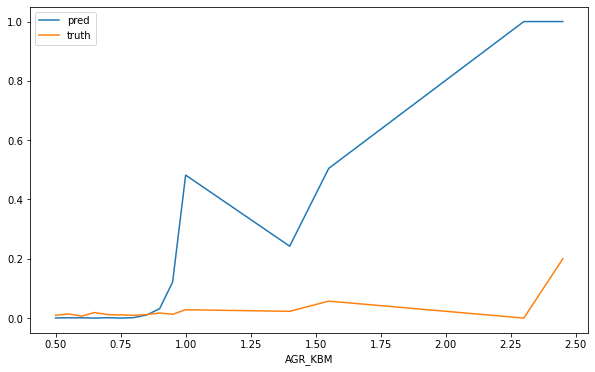

In [73]:
# аварийность по КБМ

kbmmean = res[res['f18_drv_skill_min'] > 8].groupby(['AGR_KBM']).mean()[['pred', 'truth']]
kbmmean.plot(figsize=(10, 6))

<AxesSubplot:xlabel='AGR_KBM'>

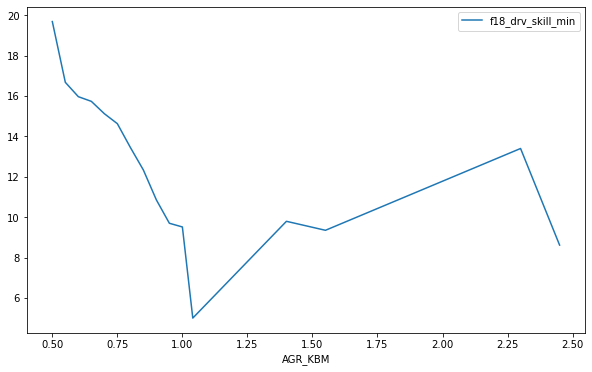

In [61]:
res.head()
kbmskill = res[['AGR_KBM', 'f18_drv_skill_min']].groupby(['AGR_KBM']).mean()
kbmskill.plot(figsize=(10, 6))

<AxesSubplot:xlabel='AGR_KBM'>

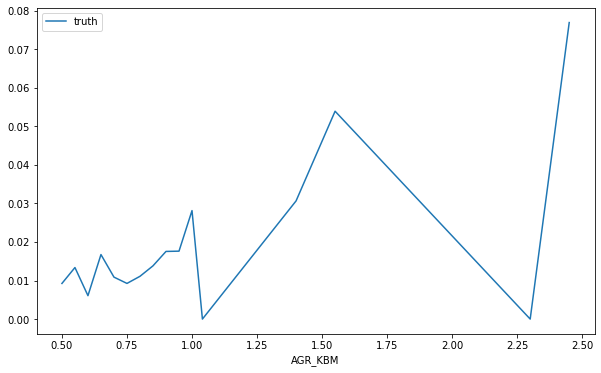

In [22]:
# аварийность по КБМ (только фактическая)

kbmmean = res.groupby(['AGR_KBM']).mean()[['truth']]
kbmmean.plot(figsize=(10, 6))

<ipython-input-18-54b9270806c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powermean['TS_POWER_G'] = powermean['TS_POWER'].apply(lambda x: round(x * 2, -2) // 2)


<AxesSubplot:xlabel='TS_POWER_G'>

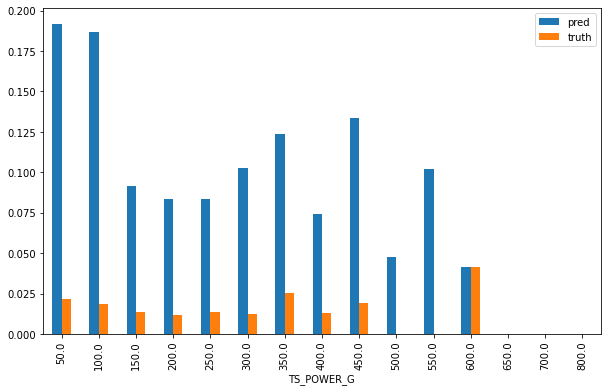

In [18]:
#аварийность по мощности

powermean = res[['TS_POWER', 'pred', 'truth']]
powermean['TS_POWER_G'] = powermean['TS_POWER'].apply(lambda x: round(x * 2, -2) // 2)
powermean = powermean.groupby(['TS_POWER_G']).mean()[['pred', 'truth']].sort_values(by='TS_POWER_G', ascending=True)
powermean.plot(kind = 'bar', c)

<AxesSubplot:xlabel='car'>

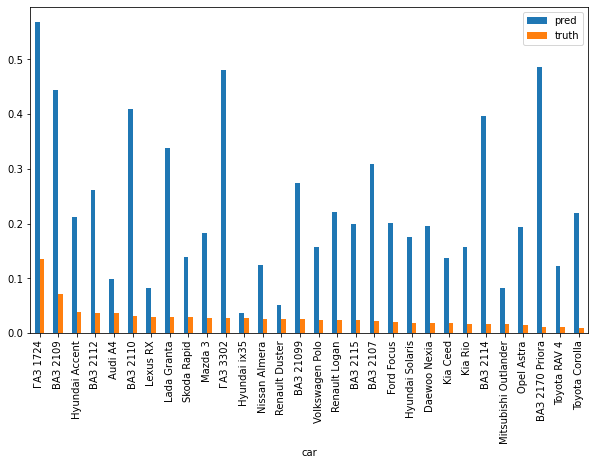

In [39]:
#аварийность по маркам, где было хотя бы несколько убытков

markmean = res
markmean['car'] = markmean['TS_MARK_NAME'] + ' ' + markmean['TS_MODEL_NAME']
cars = markmean.groupby('car').sum()['truth'].sort_values(ascending=False)
markmean = markmean[markmean['car'].isin(cars.head(30).keys())]
markmean = markmean.groupby(['car']).mean()[['pred', 'truth']].sort_values(by='truth', ascending=False)
markmean.plot(kind = 'bar', figsize=(10, 6))

<AxesSubplot:xlabel='OWN_REG'>

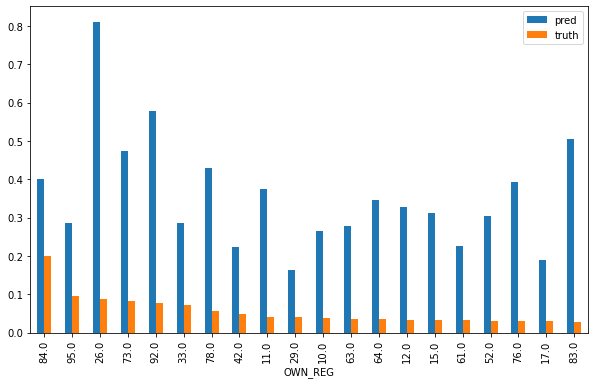

In [19]:
#аварийность по регионам

regmean = res.groupby(['OWN_REG']).mean()[['pred', 'truth']].sort_values(by='truth', ascending=False)
regmean.head(20).plot(kind = 'bar', figsize=(10, 6))